# **Final Model**

### This is the final Model, which performs the classification of the testing data, based on various stages.

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from keras.layers.core import Flatten
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from keras.preprocessing import image
from matplotlib import pyplot as plt
from PIL import Image
import copy
from tensorflow.keras.models import model_from_json
from scipy import interpolate
import pandas as pd

In [2]:
test_data_dir='dataset/test'

In [3]:
classes=[str(i) for i in range(6)]

In [15]:
test_images_per_class=150

### Lets define a function that Loads up a model from the drive.

In [19]:
def load_model(model):
  # load json and create model
  json_file = open('Models/'+model+'.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights("Models/"+model+".h5")
  print("Loaded model from disk")
  
  # evaluate loaded model on test data
  loaded_model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return loaded_model

In [20]:
model_1=load_model('filter_model_1')

Loaded model from disk


c:\python\python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
model_2=load_model('filter_model_2')

Loaded model from disk


In [22]:
model_3=load_model('filter_model_3')

Loaded model from disk


In [23]:
model_4=load_model('filter_model_4')

Loaded model from disk


In [24]:
model_5=load_model('filter_model_5')

Loaded model from disk


In [25]:
def gen_circle(img: np.ndarray, center: tuple, diameter: int,fill_val: int) -> np.ndarray:
  
    """
        Creates a matrix of ones filling a circle.
    """

    # gets the radius of the image
    radius  = diameter//2

    # gets the row and column center of the image
    row, col = center 

    # generates theta vector to variate the angle
    theta = np.arange(0, 360)*(np.pi/180)

    # generates the indexes of the column
    y = (radius*np.sin(theta)).astype("int32") 

    # generates the indexes of the rows
    x = (radius*np.cos(theta)).astype("int32") 

    # with:
    # img[x, y] = 1
    # you can draw the border of the circle 
    # instead of the inner part and the border. 

    # centers the circle at the input center
    rows = x + (row)
    cols  = y + (col)

    # gets the number of rows and columns to make 
    # to cut by half the execution
    nrows = rows.shape[0] 
    ncols = cols.shape[0]

    # makes a copy of the image
    img_copy = np.copy(img)

    # We use the simetry in our favour
    # does reflection on the horizontal axes 
    # and in the vertical axes

    for row_down, row_up, col1, col2 in zip(rows[:nrows//4],
                            np.flip(rows[nrows//4:nrows//2]),
                            cols[:ncols//4],
                            cols[nrows//2:3*ncols//4]):
    
        img_copy[row_up:row_down, col2:col1] = fill_val

 
    return img_copy

## Defining the filter functions

In [26]:
def apply_filter_1(im):
  center = (112,112)

  #red layer filter 
  diam = 25
  x_dis=40
  y_dis=50
  r_filter_dim=[(y_dis,x_dis),(224-y_dis,x_dis),(y_dis,224-x_dis),(224-y_dis,224-x_dis)]
  fil=np.zeros((224,224),dtype=int)
  for i in range(4):
    fil=gen_circle(fil,r_filter_dim[i],diam,1)
  im[:,:,0]=im[:,:,0]*fil

  #green layer filter
  g_filter_dim=[85,65]
  fil=np.zeros((224,224),dtype=int)
  g_filter_dim=[85,65]
  val=[1,0]
  fil=np.zeros((224,224),dtype=int)
  for i in range(2):
    fil=gen_circle(fil,center,2*g_filter_dim[i],val[i])
  im[:,:,1]=im[:,:,1]*fil


  #blue layer filter
  b_filter_dim=90
  fil=np.zeros((224,224),dtype=int)
  fil=gen_circle(fil,center,b_filter_dim,1)
  im[:,:,2]=im[:,:,2]*fil
  
  return im

In [27]:
def apply_filter_2(im):
  center = (112,112)
  #red layer filter 
  r_filter_dim=(24,200)
  rect=np.zeros((224,224))
  for i in range(r_filter_dim[0],r_filter_dim[1]+1):
    for j in range(r_filter_dim[0],r_filter_dim[1]+1):
      rect[i][j]=1
  im[:,:,0]=im[:,:,0]*rect

  #green layer filter
  dis=37
  g_filter_dim=[(dis,112),(112,dis),(224-dis,112),(112,224-dis)]
  circle = np.zeros((center[0]*2, center[1]*2))
  diameter = 25
  for i in range(4):
    circle = gen_circle(circle,g_filter_dim[i], diameter,1)
  im[:,:,1]=im[:,:,1]*circle


  #blue layer filter
  x=60
  b_filter_dim=[(x,x),(x,224-x),(224-x,x),(224-x,224-x),(dis,112),(112,dis),(224-dis,112),(112,224-dis)]
  circle_1 = np.zeros((center[0]*2, center[1]*2))
  diameter = 25
  for i in range(4):
    circle_1 = gen_circle(circle_1,b_filter_dim[i], diameter,1)
  im[:,:,2]=im[:,:,2]*circle_1
  return im

In [28]:
def apply_filter_4(im):
  center = (112,112)

  #red layer filter 
  r_filter_dim=(24,200)
  fil=np.zeros((224,224),dtype=int)
  for i in range(r_filter_dim[0],r_filter_dim[1]):
    for j in range(r_filter_dim[0],r_filter_dim[1]):
      fil[i][j]=1
  im[:,:,0]=im[:,:,0]*fil


  #green layer filter
  g_filter_dim=[[24,55],[224-55,200],[24,200]]
  fil=np.zeros((224,224),dtype=int)
  #1st rectangle
  for i in range(g_filter_dim[0][0],g_filter_dim[0][1]):
    for j in range(g_filter_dim[2][0],g_filter_dim[2][1]):
      fil[i][j]=1
  #2nd rectangle 
  for i in range(g_filter_dim[1][0],g_filter_dim[1][1]):
    for j in range(g_filter_dim[2][0],g_filter_dim[2][1]):
      fil[i][j]=1
  im[:,:,1]=im[:,:,1]*fil


  #blue layer filter
  b_filter_dim=[[70,100],[224-100,224-70],[24,200]]
  fil=np.zeros((224,224),dtype=int)
  #1st rectangle
  for i in range(b_filter_dim[0][0],b_filter_dim[0][1]):
    for j in range(b_filter_dim[2][0],b_filter_dim[2][1]):
      fil[i][j]=1
  #2nd rectangle 
  for i in range(b_filter_dim[1][0],b_filter_dim[1][1]):
    for j in range(b_filter_dim[2][0],b_filter_dim[2][1]):
      fil[i][j]=1
  im[:,:,2]=im[:,:,2]*fil
  
  return im

In [29]:
def apply_filter_5(im):
  center = (112,112)
  #four corner circles
  #red layer filter
  diameter=20
  r_filter_dim=[(35,35),(190,35),(35,190),(190,190)]
  fil=np.zeros((224,224),dtype=int)
  for i in range(4):
      fil=gen_circle(fil,r_filter_dim[i],diameter,1); 
  
  im[:,:,0]=im[:,:,0]*fil


  #green layer filter
  # G filter
# a circle
  diameter_g=180
  g_filter_dim=(112,112)
  fil=np.zeros((224,224),dtype=int)
  fil=gen_circle(fil,g_filter_dim,diameter_g,1)
  im[:,:,1]=im[:,:,1]*fil


  #blue layer filter
  b_filter_dim=[30,195]
  fil=np.zeros((224,224),dtype=int)
  #1st rectangle
  for i in range(b_filter_dim[0],b_filter_dim[1]):
    for j in range(b_filter_dim[0],b_filter_dim[1]):
      fil[i][j]=1
  im[:,:,2]=im[:,:,2]*fil
  
  return im

### The following function takes an array as an input and predicts the class of the image array.

In [30]:
def build_and_predict(arr):
  img_arr_1=copy.deepcopy(arr)
  img_arr_1=apply_filter_1(img_arr_1)
  img_arr_1=img_arr_1.reshape(1,224,224,3)
  label=np.argmax(model_1.predict(preprocess_input(copy.deepcopy(img_arr_1))))
  if label==0:
    img_arr_2=copy.deepcopy(arr)
    img_arr_2=apply_filter_2(img_arr_2)
    img_arr_2=img_arr_2.reshape(1,224,224,3)
    label_2=np.argmax(model_2.predict(preprocess_input(copy.deepcopy(img_arr_2))))
    return label_2
  else:
    img_arr_3=copy.deepcopy(arr.reshape(1,224,224,3))
    label_3=np.argmax(model_3.predict(preprocess_input(copy.deepcopy(img_arr_3))))
    if label_3==0:
      img_arr_4=copy.deepcopy(arr)
      img_arr_4=apply_filter_4(img_arr_4)
      img_arr_4=img_arr_4.reshape(1,224,224,3)
      label_4=np.argmax(model_4.predict(preprocess_input(copy.deepcopy(img_arr_4))))
      return (label_4+2)
    else:
      img_arr_5=copy.deepcopy(arr)
      img_arr_5=apply_filter_5(img_arr_5)
      img_arr_5=img_arr_5.reshape(1,224,224,3)
      label_5=np.argmax(model_5.predict(preprocess_input(copy.deepcopy(img_arr_5))))
      return (label_5+4);

In [31]:
img_path='dataset/test/0/120.png'
img=image.load_img(img_path,target_size=(224,224))
img_data=np.asarray(img)
build_and_predict(np.array(img_data))

0

In [32]:
test_data_dir='dataset/test'

In [33]:
test_data=[]
test_label=[]
img_height,img_width=224,224
for cls in classes:
    for i in range(test_images_per_class):
        img_path=test_data_dir+'/'+cls+'/'+str(i)+'.png'
        img=image.load_img(img_path,target_size=(img_height,img_width))
        img_data=np.asarray(img)
        test_data.append(img_data)
        test_label.append(int(cls))

In [34]:
test_data=np.asarray(test_data)
test_label=np.asarray(test_label)

In [35]:
predictions=[]
for i in range(test_data.shape[0]):
    predictions.append(build_and_predict(test_data[i]))

In [36]:
predictions=np.array(predictions).reshape(6,test_images_per_class)

In [37]:
test_label=test_label.reshape(6,test_images_per_class)

In [38]:
acc_each_class=[]
for cls in range(6):
    cnt=0
    for i in range(test_images_per_class):
        if test_label[cls][i]==predictions[cls][i]:
            cnt+=1
    acc_each_class.append(cnt)

In [39]:
acc_each_class=np.array(acc_each_class)

In [40]:
acc_each_class=[i*100/150 for i in acc_each_class]

In [50]:
acc_each_class

[88.66666666666667,
 80.66666666666667,
 57.333333333333336,
 69.33333333333333,
 60.666666666666664,
 38.0]

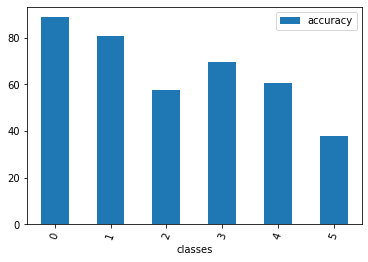

In [49]:
data = {"accuracy":acc_each_class,

        "classes":[i for i in range(6)]

        };

dataFrame = pd.DataFrame(data=data);

# Draw a vertical bar chart

dataFrame.plot.bar(y="accuracy", x="classes", rot=70);
